In [2]:
!pip install opencv-python

  Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl (54.8 MB)


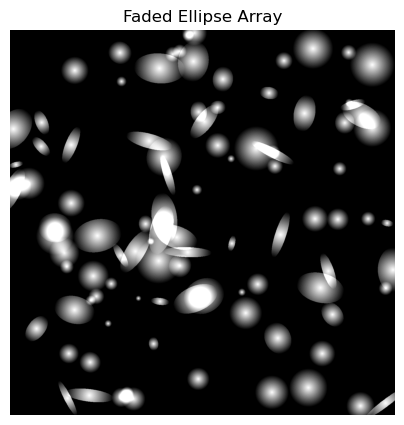

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_fade_ellipse_array(shape, num_ellipses, max_radius):
    array = np.zeros(shape, dtype=np.float32)  # Create an empty float32 array for the final image

    for _ in range(num_ellipses):
        # Random center position
        center = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        # Random axes length
        axes = (np.random.randint(10, max_radius), np.random.randint(10, max_radius))
        # Random angle
        angle = np.random.randint(0, 360)

        # Create a blank mask for the ellipse
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.ellipse(mask, center, axes, angle, 0, 360, 1, -1)  # Draw the filled ellipse on the mask

        # Create a gradient for the ellipse
        y_indices, x_indices = np.ogrid[:shape[0], :shape[1]]
        # Calculate distance from the center
        distance = np.sqrt((x_indices - center[0]) ** 2 + (y_indices - center[1]) ** 2)
        # Normalize distances and set the fade effect
        fade = np.clip((axes[0] - distance) / axes[0], 0, 1)  # Create a fade effect

        # Create a gradient based on the fade effect, using the mask to only consider ellipse areas
        gradient = fade * mask.astype(np.float32)  # Ensure the mask is float32 for multiplication

        # Add the gradient to the array (ensuring both are float32)
        array = np.clip(array + gradient, 0, 1)  # Clip to avoid overflow

    return array

# Generate the first faded ellipse array
shape = (1500, 1500)
num_ellipses = 100
max_radius = 100

arr1 = generate_fade_ellipse_array(shape, num_ellipses, max_radius)

# Display the faded ellipse array
plt.figure(figsize=(5, 5))
plt.imshow(arr1, cmap='gray')
plt.title('Faded Ellipse Array')
plt.axis('off')  # Hide axis
plt.show()

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_fade_ellipse_array(shape, num_ellipses, max_radius):
    array = np.zeros(shape, dtype=np.float32)  # Use float for gradient values
    for _ in range(num_ellipses):
        # Random center position
        center = (np.random.randint(0, shape[1]), np.random.randint(0, shape[0]))
        # Random axes length
        axes = (np.random.randint(10, max_radius), np.random.randint(10, max_radius))
        # Random angle
        angle = np.random.randint(0, 360)

        # Create a blank mask for the ellipse
        mask = np.zeros(shape, dtype=np.uint8)
        cv2.ellipse(mask, center, axes, angle, 0, 360, 1, -1)

        # Create a gradient for the ellipse
        gradient = np.zeros(shape, dtype=np.float32)
        y_indices, x_indices = np.ogrid[:shape[0], :shape[1]]
        # Calculate distance from the center
        distance = np.sqrt((x_indices - center[0]) ** 2 + (y_indices - center[1]) ** 2)
        # Normalize distances and set the fade effect
        fade = np.clip((axes[0] - distance) / axes[0], 0, 1)
        # Apply fade to the mask to create the gradient
        gradient = cv2.multiply(fade.astype(np.float32), mask.astype(np.float32))

        # Add the gradient to the array (ensuring both are float32)
        array += gradient  # Use += for in-place addition

    return array

def shift_and_deform_image(image, shift_x, shift_y, deformation_strength):
    # Shift the image
    shifted_image = np.roll(image, shift=(shift_y, shift_x), axis=(0, 1))

    # Create an affine transformation matrix for deformation
    rows, cols = image.shape
    # Deformation transformation (randomly varying points)
    pts1 = np.float32([[0, 0], [cols - 1, 0], [0, rows - 1]])
    pts2 = np.float32([[0 + deformation_strength * np.random.rand(), 0 + deformation_strength * np.random.rand()],
                        [cols - 1 + deformation_strength * np.random.rand(), 0 + deformation_strength * np.random.rand()],
                        [0 + deformation_strength * np.random.rand(), rows - 1 + deformation_strength * np.random.rand()]])
    
    M = cv2.getAffineTransform(pts1, pts2)
    deformed_image = cv2.warpAffine(shifted_image, M, (cols, rows))

    return deformed_image



In [116]:
# Parameters
shape = (4000, 4000)
num_ellipses = 2000
max_radius = 100


# Generate the faded ellipse array
arr1 = generate_fade_ellipse_array(shape, num_ellipses, max_radius)

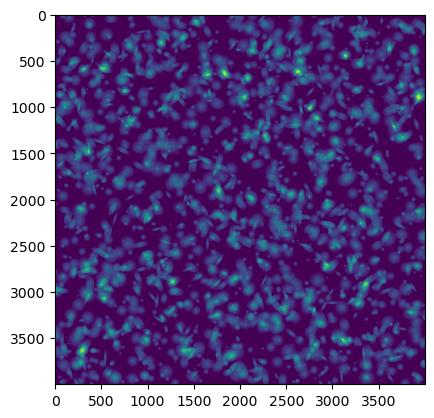

In [140]:
plt.imshow(arr1)
plt.show()

In [150]:
shift_x = 200  # Shift by 50 pixels horizontally
shift_y = 100  # Shift by 30 pixels vertically
deformation_strength = 40  # Max deformation strength
# Apply shift and deformation
arr2 = shift_and_deform_image(arr1, shift_x, shift_y, deformation_strength)


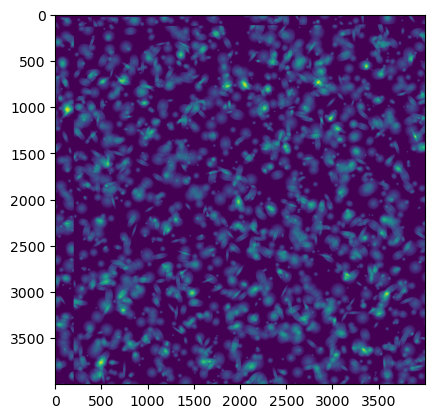

In [151]:
plt.imshow(arr2)
plt.show()

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

# Function to warp an image with adjustable grid granularity
def warp_image(image, warp_strength=5, frequency=50, granularity=1):
    # Get the shape of the image
    height, width = image.shape[:2]

    # Create a grid of coordinates
    y_indices, x_indices = np.indices((height, width))

    # Apply a sine wave to the x-coordinates with specified granularity
    # The granularity affects the frequency of the warp
    x_warped = x_indices + warp_strength * np.sin(2 * np.pi * y_indices / (frequency * granularity))

    # Ensure that the warped indices are within the image dimensions
    x_warped = np.clip(x_warped, 0, width - 1)

    # Use map_coordinates to warp the image
    warped_image = map_coordinates(image, [y_indices, x_warped], order=1)

    return warped_image



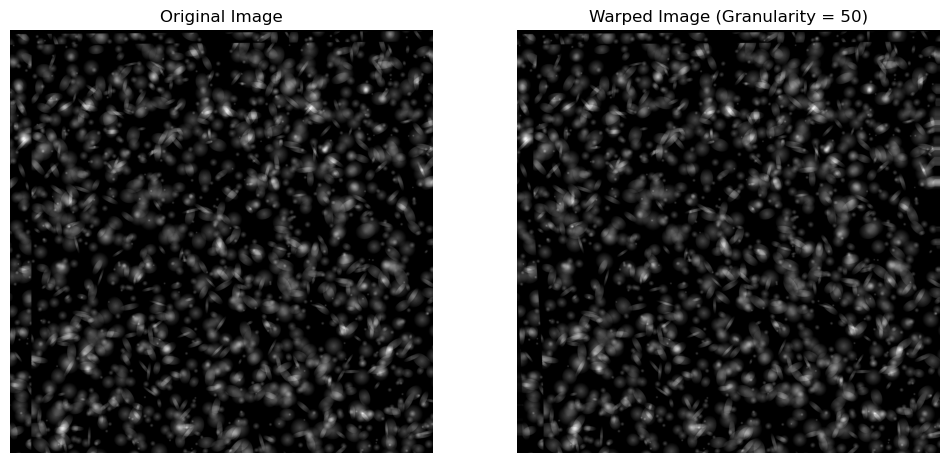

In [168]:
# Load your image as a NumPy array
# For demonstration, we'll create a simple gradient image
original_image = arr2

# Apply the warp with specified granularity
warp_strength = 50
frequency = 100
granularity = 50  # Adjust this value for less granular (greater than 1) or more granular (1 or less)
warped_image = warp_image(original_image, warp_strength=warp_strength, frequency=frequency, granularity=granularity)

# Display the original and warped images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Warped Image (Granularity = {})'.format(granularity))
plt.imshow(warped_image, cmap='gray')
plt.axis('off')

plt.show()

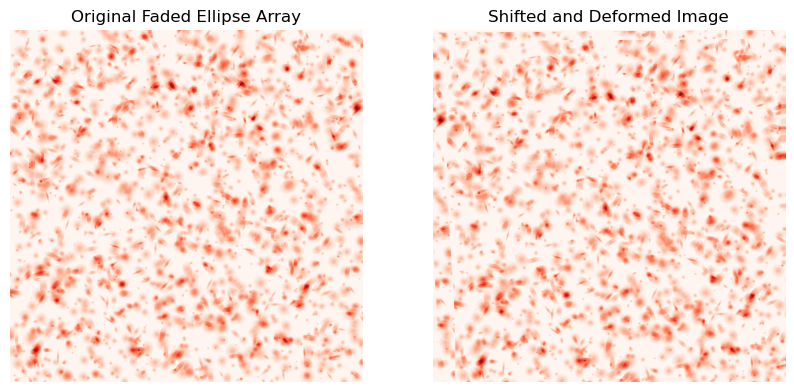

In [169]:
# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(arr1, cmap='Reds')
plt.title('Original Faded Ellipse Array')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(warped_image, cmap='Reds')
plt.title('Shifted and Deformed Image')
plt.axis('off')

plt.show()

In [95]:
import cv2
import numpy as np

def affine_registration(fixed, moving, num_levels=3, max_iterations=50):
    # Ensure images are in the correct format
    fixed = fixed.astype(np.float32)
    moving = moving.astype(np.float32)
    
    # Normalize images to [0, 255] range
    fixed = cv2.normalize(fixed, None, 0, 255, cv2.NORM_MINMAX)
    moving = cv2.normalize(moving, None, 0, 255, cv2.NORM_MINMAX)
    
    # Convert to 8-bit images
    fixed = fixed.astype(np.uint8)
    moving = moving.astype(np.uint8)
    
    # Create image pyramids
    fixed_pyramid = [fixed]
    moving_pyramid = [moving]
    for _ in range(num_levels - 1):
        fixed_pyramid.append(cv2.pyrDown(fixed_pyramid[-1]))
        moving_pyramid.append(cv2.pyrDown(moving_pyramid[-1]))
    
    # Reverse pyramids to go from coarse to fine
    fixed_pyramid.reverse()
    moving_pyramid.reverse()
    
    # Start with identity transform
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    # Process from coarse to fine
    for level in range(num_levels):
        fixed_image = fixed_pyramid[level]
        moving_image = moving_pyramid[level]
        
        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, max_iterations, 1e-5)
        
        # Find the affine transformation
        try:
            cc, warp_matrix = cv2.findTransformECC(
                fixed_image, 
                moving_image, 
                warp_matrix, 
                cv2.MOTION_AFFINE, 
                criteria,
                inputMask=None,
                gaussFiltSize=1
            )
        except cv2.error:
            print(f"Warning: ECC algorithm didn't converge at level {level}")
            break
        
        # If not at the finest level, scale up the warp matrix for the next level
        if level < num_levels - 1:
            warp_matrix[:, 2] *= 2
    
    # Apply the final transformation to the original moving image
    height, width = fixed.shape
    registered = cv2.warpAffine(moving, warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    return registered, warp_matrix

In [170]:
# Example usage
fixed = arr1  # Replace with your actual fixed image
moving = warped_image # Replace with your actual moving image

registered, warp_matrix = affine_registration(fixed, moving)

print("Registration complete.")
print("Registered image shape:", registered.shape)
print("Warp matrix:", warp_matrix)

Registration complete.
Registered image shape: (4000, 4000)
Warp matrix: [[ 1.0006957e+00  1.8288035e-02 -7.1175568e+01]
 [-1.1760771e-02  9.7817498e-01  7.8589836e+01]]


In [91]:
fixed.shape

(4000, 4000)

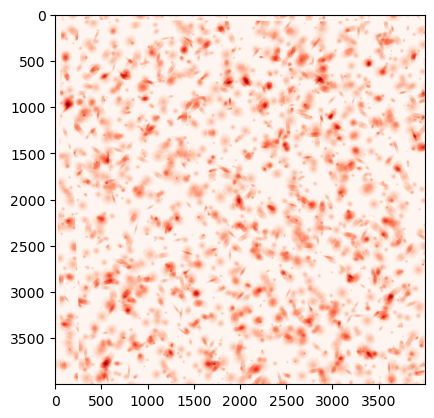

In [171]:
plt.imshow(registered, cmap='Reds')
plt.show()

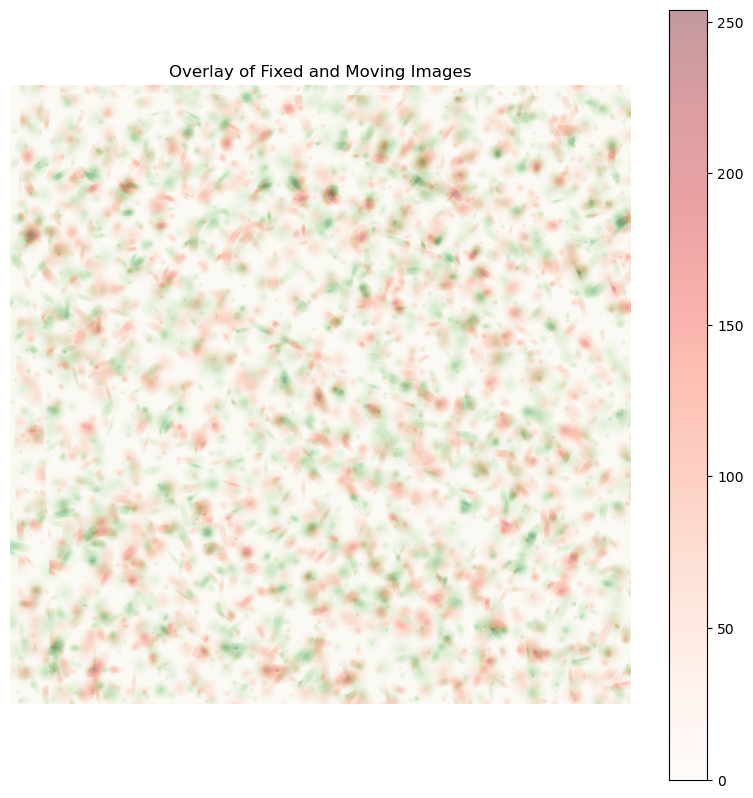

In [172]:
plt.figure(figsize=(10, 10))
plt.imshow(fixed, cmap='Greens', alpha=0.8)  # Display fixed image in grayscale
plt.imshow(registered, cmap='Reds', alpha=0.4)  # Overlay moving image with transparency

plt.title('Overlay of Fixed and Moving Images')
plt.axis('off')  # Turn off axis
plt.colorbar()  # Optionally add a colorbar
plt.show()

In [2]:
import tifffile as tiff


In [3]:
tiff.imwrite()

TypeError: imwrite() missing 1 required positional argument: 'file'

In [4]:
!bfconvert -noflat -bigtiff \ 
         -tilex 512 \
         -tiley 512 \
         -pyramid-resolutions 3 \
         -pyramid-scale 2 \
         /hpcnfs/scratch/DIMA/chiodin/tests/Notebooks/img_1000_1000.tiff /hpcnfs/scratch/DIMA/chiodin/tests/Notebooks/img_1000_1000.ome.tiff

IndentationError: unexpected indent (3222902693.py, line 2)